In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

%matplotlib inline

In [11]:
dir_path = "../input/YouTube-Spam-Collection-v1/"

dfs = []
for f in os.listdir(dir_path):
    path = "{}/{}".format(dir_path, f)
    df = pd.read_csv(path)
    dfs.append(df)

df = pd.concat(dfs, axis=0)[["CONTENT", "CLASS"]]
df["category_id"] = df.CLASS.factorize()[0]
df = shuffle(df)
df.head()

,CONTENT,CLASS,category_id
348,Subscribe to my channel <br />Tweet &amp; Foll...,1,1
376,Check out this video on YouTube:﻿,1,1
80,http://woobox.com/33gxrf/brt0u5 FREE CS GO!!!!﻿,1,1
180,You guys should check out this EXTRAORDINARY w...,1,1
235,Megan Fox is gorg in this!! Eminem is truly th...,0,0


In [12]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[:1500], df[:1500]["category_id"], num_epochs=None, shuffle=True)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[1500:], df[1500:]["category_id"], shuffle=False)

In [19]:
embedded_text_feature_column = hub.text_embedding_column(
        key="CONTENT", 
        #module_spec="https://tfhub.dev/google/Wiki-words-500/1")
        module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.
INFO:tensorflow:Downloading https://tfhub.dev/google/nnlm-en-dim128/1: 368.07MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/nnlm-en-dim128/1, Total size: 483.54MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.


In [20]:
estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpk7k6em6c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14438f978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
estimator.train(input_fn=train_input_fn, steps=800);
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpk7k6em6c/model.ckpt.
INFO:tensorflow:loss = 87.9935, step = 1
INFO:tensorflow:global_step/sec: 271.489
INFO:tensorflow:loss = 25.86057, step = 101 (0.369 sec)
INFO:tensorflow:global_step/sec: 326.364
INFO:tensorflow:loss = 21.615122, step = 201 (0.306 sec)
INFO:tensorflow:global_step/sec: 348.936
INFO:tensorflow:loss = 12.985117, step = 301 (0.286 sec)
INFO:tensorflow:global_step/sec: 358.202
INFO:tensorflow:loss = 7.600339, step = 401 (0.279 sec)
INFO:tensorflow:global_step/sec: 33

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpk7k6em6c/model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


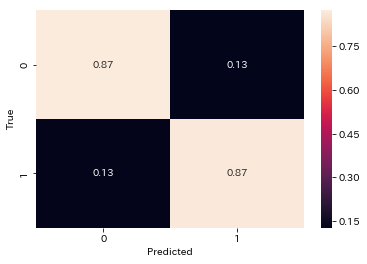

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    0, 1
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(df[1500:]["category_id"], 
                           get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");